In [1]:
library(tidyverse, quietly = TRUE)
library(survival, quietly = TRUE)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


- Steroid: 1(2), 1+(2), 4+, 5, 7, 8, 10, 10+, 12+, 16+(3)
• Control: 1, 2, 3(2), 3+, 5+(2), 16+(8)

In [2]:
treatment_survival_times = c(1, 1, 1, 1, 4, 5, 7, 8, 10, 10, 12, 16, 16, 16)
treatment_censored = c(0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1)
control_survival_times = c(1, 2, 3, 3, 3, 5, 5, rep(16, 8))
control_censored = c(0, 0, 0, 0, rep(1, 11))

data = data.frame(
    treatment = c(rep(1, length(treatment_survival_times)), rep(0, length(control_survival_times))),
    t = c(treatment_survival_times, control_survival_times),
    censored = c(treatment_censored, control_censored)
)

head(data)

,treatment,t,censored
,<dbl>,<dbl>,<dbl>
1,1,1,0
2,1,1,0
3,1,1,1
4,1,1,1
5,1,4,1
6,1,5,0


**(a) Find Kaplan-Meier estimator of survival function for each group (with standard error) by completing the following table:**

In [3]:
calc_KM = function(data){
    data %>%
        mutate(n_units = n()) %>%
        group_by(t) %>%
        summarize(
            D = sum(1 - censored), # count deaths
            n_events = n(), # count events plus censorings
            n_units = first(n_units) # count total number of units in the group
        ) %>%
        mutate(
            N = n_units - lag(cumsum(n_events), n = 1, default = 0), # count number of units at risk
            S = N - D, # count number of survivors
        ) %>%
        select(t, D, N, S) %>%
        mutate(
            S_t_hat = cumprod(S / N), # Kaplan-Meier estimate of survival function
            S_t_hat_se = S_t_hat*sqrt(cumsum(D/(N*(N - D)))), # standard error of Kaplan-Meier estimate of survival function
            h_hat = D / N, # hazard rate
            H_hat = cumsum(h_hat) # cumulative hazard rate
        )
}
treat_km = calc_KM(data %>% filter(treatment == 1))
control_km = calc_KM(data %>% filter(treatment == 0))

In [4]:
treat_km

t,D,N,S,S_t_hat,S_t_hat_se,h_hat,H_hat
<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2,14,12,0.8571429,0.09352195,0.1428571,0.1428571
4,0,10,10,0.8571429,0.09352195,0.0000000,0.1428571
5,1,9,8,0.7619048,0.12236497,0.1111111,0.2539683
7,1,8,7,0.6666667,0.13928515,0.1250000,0.3789683
8,1,7,6,0.5714286,0.14841785,0.1428571,0.5218254
10,1,6,5,0.4761905,0.15118103,0.1666667,0.6884921
12,0,4,4,0.4761905,0.15118103,0.0000000,0.6884921
16,0,3,3,0.4761905,0.15118103,0.0000000,0.6884921


In [5]:
control_km

t,D,N,S,S_t_hat,S_t_hat_se,h_hat,H_hat
<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,15,14,0.9333333,0.06440612,0.06666667,0.06666667
2,1,14,13,0.8666667,0.08777075,0.07142857,0.13809524
3,2,13,11,0.7333333,0.11417985,0.15384615,0.29194139
5,0,10,10,0.7333333,0.11417985,0.00000000,0.29194139
16,0,8,8,0.7333333,0.11417985,0.00000000,0.29194139


**(b) Plot survival curve (using eithor R or SAS) for each group based on Kaplan-Meier method. What is median survival in each group? Please also include the output from R and SAS which should give you the same result as in (a).**

In [6]:
fit = survfit(
    Surv(t, status) ~ treatment,
    data = data %>% mutate(status = 1 - censored),
    conf.type = "log-log"
)

fit

summary(fit)

Call: survfit(formula = Surv(t, status) ~ treatment, data = data %>% 
    mutate(status = 1 - censored), conf.type = "log-log")

             n events median 0.95LCL 0.95UCL
treatment=0 15      4     NA       3      NA
treatment=1 14      6     10       5      NA

Call: survfit(formula = Surv(t, status) ~ treatment, data = data %>% 
    mutate(status = 1 - censored), conf.type = "log-log")

                treatment=0 
 time n.risk n.event survival std.err lower 95% CI upper 95% CI
    1     15       1    0.933  0.0644        0.613        0.990
    2     14       1    0.867  0.0878        0.564        0.965
    3     13       2    0.733  0.1142        0.436        0.891

                treatment=1 
 time n.risk n.event survival std.err lower 95% CI upper 95% CI
    1     14       2    0.857  0.0935        0.539        0.962
    5      9       1    0.762  0.1224        0.421        0.918
    7      8       1    0.667  0.1393        0.329        0.863
    8      7       1    0.571  0.1484        0.249        0.798
   10      6       1    0.476  0.1512        0.180        0.726


So, the median survival in treatment is 10, and we're getting NA for the median survival in control. I'm not sure exactly what the problem here is, but it might be underdetermined.

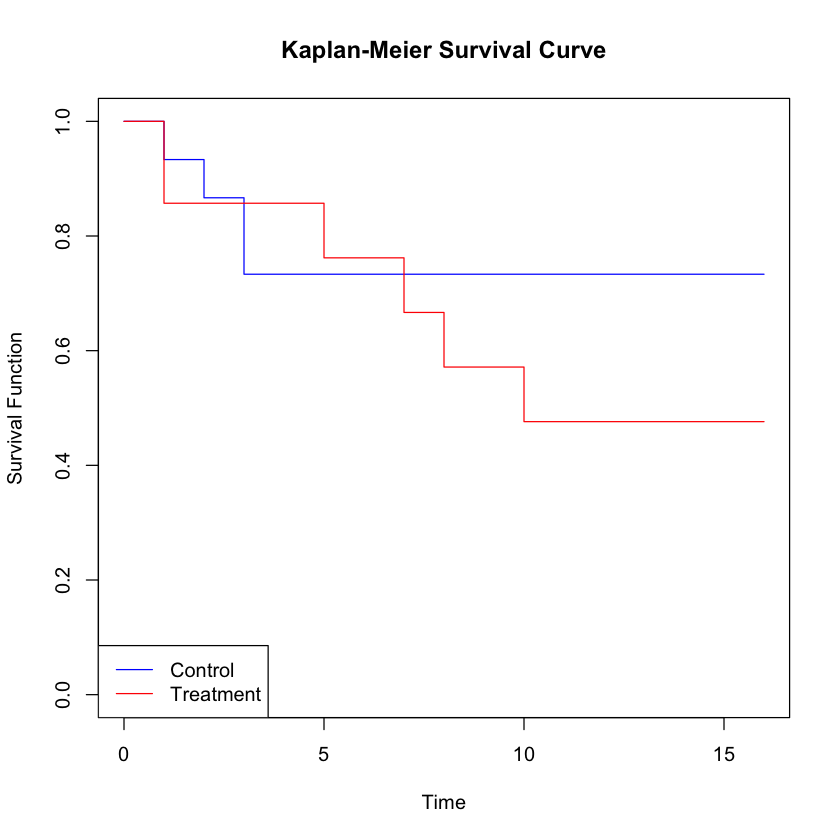

In [7]:
par(bg="white")
plot(
    fit,
    col = c("blue", "red"),
    lty = 1,
    xlab = "Time",
    ylab = "Survival Function",
    main = "Kaplan-Meier Survival Curve"
)
legend("bottomleft", legend = c("Control", "Treatment"), col = c("blue", "red"), lty=1)


**(c) Plot survival curve (eithor R or SAS) for each group based on Life-table. Is there anydifference between approaches (b) and (c)?**

In [8]:
calc_lt = function(data, bin_starts){
    life_table = data.frame(start = bin_starts)
    life_table = life_table %>%
        mutate(
            end = lead(start, default = Inf),
            D = mapply(\(s, e) sum(data$t >= s & data$t < e & data$censored == 0), start, end), # count deaths
            C = mapply(\(s, e) sum(data$t >= s & data$t < e & data$censored == 1), start, end), # count censorings
            N = nrow(data) - lag(cumsum(D + C), n = 1, default = 0), # count number of units at risk
            N_avg = N - (C / 2), # life table estimator of number of units at risk
            h_hat = D / N_avg, # hazard rate estimator
            s_hat = cumprod(1 - h_hat) # survival function estimator
        )
    return(life_table)
}

# bin size is 2
bin_starts = seq(0, 16, by = 2)

treat_lt = calc_lt(data %>% filter(treatment == 1), bin_starts)
control_lt = calc_lt(data %>% filter(treatment == 0), bin_starts)

In [9]:
treat_lt

start,end,D,C,N,N_avg,h_hat,s_hat
<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
0,2,2,2,14,13.0,0.1538462,0.8461538
2,4,0,0,10,10.0,0.0000000,0.8461538
4,6,1,1,10,9.5,0.1052632,0.7570850
6,8,1,0,8,8.0,0.1250000,0.6624494
8,10,1,0,7,7.0,0.1428571,0.5678138
10,12,1,1,6,5.5,0.1818182,0.4645749
12,14,0,1,4,3.5,0.0000000,0.4645749
14,16,0,0,3,3.0,0.0000000,0.4645749
16,Inf,0,3,3,1.5,0.0000000,0.4645749


In [10]:
control_lt

start,end,D,C,N,N_avg,h_hat,s_hat
<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
0,2,1,0,15,15.0,0.06666667,0.9333333
2,4,3,1,14,13.5,0.22222222,0.7259259
4,6,0,2,10,9.0,0.00000000,0.7259259
6,8,0,0,8,8.0,0.00000000,0.7259259
8,10,0,0,8,8.0,0.00000000,0.7259259
10,12,0,0,8,8.0,0.00000000,0.7259259
12,14,0,0,8,8.0,0.00000000,0.7259259
14,16,0,0,8,8.0,0.00000000,0.7259259
16,Inf,0,8,8,4.0,0.00000000,0.7259259


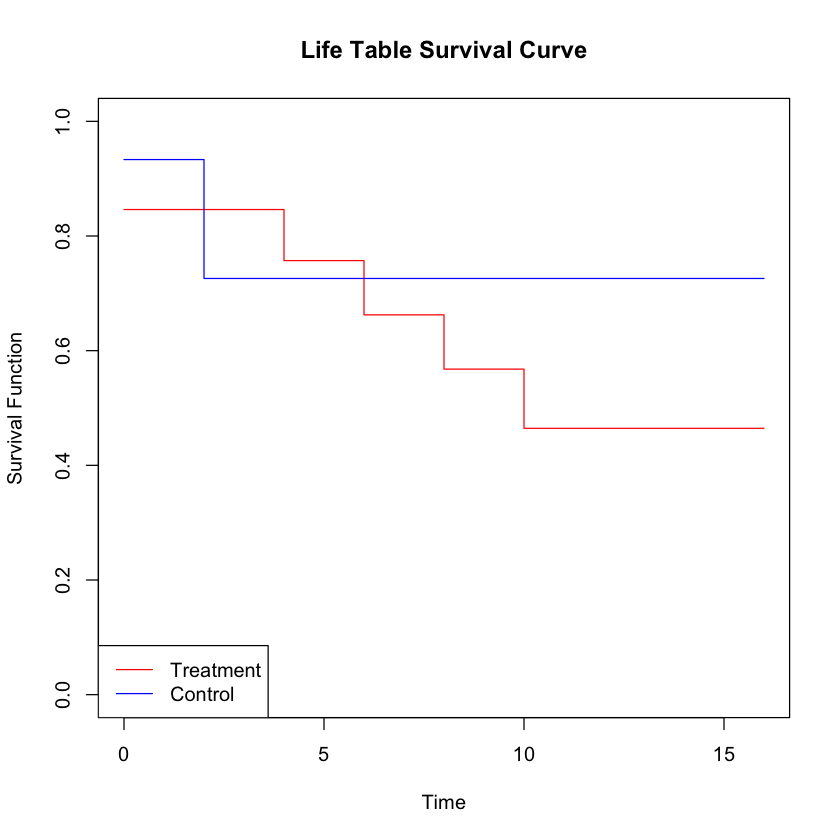

In [11]:
par(bg="white")
plot(
    bin_starts,
    treat_lt$s_hat,
    type = "s",
    col = "red",
    xlab = "Time",
    ylab = "Survival Function",
    main = "Life Table Survival Curve",
    ylim = c(0, 1)
)
lines(
    bin_starts,
    control_lt$s_hat,
    type = "s",
    col = "blue"
)
legend("bottomleft", legend = c("Treatment", "Control"), col = c("red", "blue"), lty=1)

This is similar to (b), but the life table is using a bin size of 2, and the Kaplan-Meier is using a bin size of 1. So, one difference is that the survival curve of the control group only has one decrement here, since all of the deaths happened in the first and second bins.

**(d) What is the p-value from log-rank test between two groups? Please state the null and alternative hypotheses.**

The null hypothesis is that the two curvival curves are the same. The alternative hypothesis is that they are different.

$$
H_0 = S_1(t) = S_2(t)
$$

$$
H_1 = S_1(t) \neq S_2(t)
$$

In [12]:
fit = survdiff(
    Surv(t, status) ~ treatment,
    data = data %>% mutate(status = 1 - censored),
    # conf.type = "log-log"
)

fit

Call:
survdiff(formula = Surv(t, status) ~ treatment, data = data %>% 
    mutate(status = 1 - censored))

             N Observed Expected (O-E)^2/E (O-E)^2/V
treatment=0 15        4      5.4     0.361     0.812
treatment=1 14        6      4.6     0.424     0.812

 Chisq= 0.8  on 1 degrees of freedom, p= 0.4 

The p-value is 0.4. So, we cannot reject the null hypothesis that the two survival curves are the same.

**(e) Can you estimate the mean survival (a non-parametric method) for each group based on the table in (a)?**

We can estimate mean survival time from Kaplan-Meier by integrating the survival curve with respect to time. Because it's a step function, we can do this by summing the product of the time increment and the survival function in the time increment.

In [13]:
treat_km %>%
    mutate(
        # width of each bin
        t_inc = t - lag(t, n = 1, default = 0),
        # height of each bin
        t_inc_times_S_t_hat = t_inc * lag(S_t_hat, default = 1)
    ) %>%
    summarize(
        mean_survival = sum(t_inc_times_S_t_hat)
    )

control_km %>%
    mutate(
        t_inc = t - lag(t, n = 1, default = 0),
        t_inc_times_S_t_hat = t_inc * lag(S_t_hat, default = 1)
    ) %>%
    summarize(
        mean_survival = sum(t_inc_times_S_t_hat)
    )

mean_survival
<dbl>
10.61905


mean_survival
<dbl>
12.33333


So, we estimate a mean survival time of 10.61905 for the treatment group, and 12.33333 for the control group.